In [1]:
# CELDA 1: Imports y carga de datos procesados

import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

clean_path = r"D:\UTP\AeroCVer\aerosafe-risk-predictor\data\processed\bird_strikes_clean.csv"
df = pd.read_csv(clean_path)

df.head()

,AircraftType,AirportName,AltitudeBin,MakeModel,WildlifeSize,ConditionsSky,PilotWarned,FlightPhase,Month,Year,IsSevere
0,Airplane,LAGUARDIA NY,"(1000, 2000]",B-737-400,Medium,No Cloud,N,Climb,11,2000,1
1,Airplane,DALLAS/FORT WORTH INTL ARPT,"(-1, 0]",MD-80,Small,Some Cloud,Y,Landing Roll,7,2001,1
2,Airplane,LAKEFRONT AIRPORT,"(30, 50]",C-500,Small,No Cloud,N,Approach,9,2001,0
3,Airplane,SEATTLE-TACOMA INTL,"(30, 50]",B-737-400,Small,Some Cloud,Y,Climb,9,2002,0
4,Airplane,NORFOLK INTL,"(30, 50]",CL-RJ100/200,Small,No Cloud,N,Approach,6,2003,0


In [2]:
# CELDA 2: Selección de variables y codificación one-hot

cols_for_anomaly = [
    'AircraftType', 'AirportName', 'AltitudeBin', 'MakeModel',
    'WildlifeSize', 'ConditionsSky', 'FlightPhase',
    'Month', 'Year', 'IsSevere'
]

df_anom = df[cols_for_anomaly].copy()

# One-hot encoding de categóricas
df_encoded = pd.get_dummies(df_anom, drop_first=True)

df_encoded.shape, df_encoded.head()

((25429, 1456),
    Month  Year  IsSevere  AirportName_ABILENE REGIONAL ARPT  AirportName_ABRAHAM LINCOLN CAPITAL ARPT  \
 0     11  2000         1                              False                                     False   
 1      7  2001         1                              False                                     False   
 2      9  2001         0                              False                                     False   
 3      9  2002         0                              False                                     False   
 4      6  2003         0                              False                                     False   
 
    AirportName_ADAMS COUNTY- LEGION FIELD  AirportName_ADAMS FIELD ARPT  AirportName_ADDINGTON FIELD ARPT  \
 0                                   False                         False                             False   
 1                                   False                         False                             False   
 2              

In [3]:
# CELDA 3: Entrenar IsolationForest para detectar incidentes anómalos

# Definimos el modelo
iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,   # suponemos ~2% de anomalías
    random_state=42
)

iso.fit(df_encoded)

# El método score_samples da un "anomaly score" (más bajo = más raro)
scores = iso.score_samples(df_encoded)

# Guardamos el score (multiplicado por -1 para que mayor = más raro)
df['anomaly_score'] = -scores

df[['anomaly_score']].describe()

,anomaly_score
count,25429.000000
mean,0.320810
std,0.007026
min,0.301401
25%,0.315932
50%,0.320496
75%,0.325259
max,0.351810


Cantidad de anomalías detectadas: 509


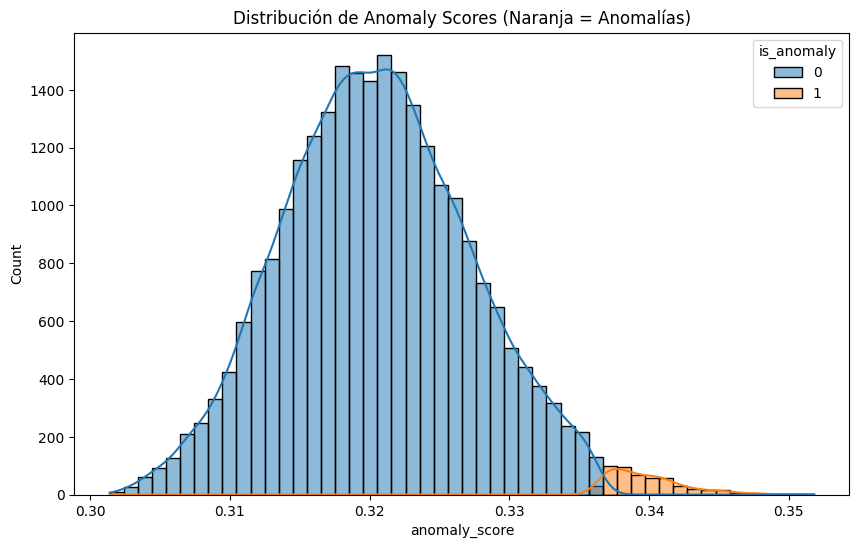

In [4]:
# CELDA 4: Marcar anomalías y visualizar distribución
# IsolationForest devuelve -1 para anomalías y 1 para normales
df['is_anomaly'] = iso.predict(df_encoded)
df['is_anomaly'] = df['is_anomaly'].map({1: 0, -1: 1}) # 1: Anomalía, 0: Normal

print(f"Cantidad de anomalías detectadas: {df['is_anomaly'].sum()}")

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='anomaly_score', hue='is_anomaly', bins=50, kde=True)
plt.title("Distribución de Anomaly Scores (Naranja = Anomalías)")
plt.show()

In [5]:
# CELDA 5: Comparativa de perfiles (Normal vs Anomalía)
print("--- Proporción de Daño Grave (IsSevere) ---")
print(df.groupby('is_anomaly')['IsSevere'].mean())

print("\n--- Top Aeropuertos en Anomalías ---")
print(df[df['is_anomaly'] == 1]['AirportName'].value_counts().head(10))

print("\n--- Top Fases de Vuelo en Anomalías ---")
print(df[df['is_anomaly'] == 1]['FlightPhase'].value_counts().head(5))

--- Proporción de Daño Grave (IsSevere) ---
is_anomaly
0    0.089446
1    0.442043
Name: IsSevere, dtype: float64

--- Top Aeropuertos en Anomalías ---
AirportName
BALTIMORE WASH INTL             101
SACRAMENTO INTL                  45
ORLANDO INTL                     38
DALLAS/FORT WORTH INTL ARPT      35
KANSAS CITY INTL                 32
PHILADELPHIA INTL                20
CHICAGO O'HARE INTL ARPT         20
GEORGE BUSH INTERCONTINENTAL     16
EPPLEY AIRFIELD                  15
LOS ANGELES INTL                 11
Name: count, dtype: int64

--- Top Fases de Vuelo en Anomalías ---
FlightPhase
Climb           216
Approach        161
Descent         117
Take-off run     14
Landing Roll      1
Name: count, dtype: int64


In [6]:
# CELDA 6: Los 5 casos más anómalos
df.sort_values(by='anomaly_score', ascending=False).head(5)

,AircraftType,AirportName,AltitudeBin,MakeModel,WildlifeSize,ConditionsSky,PilotWarned,FlightPhase,Month,Year,IsSevere,anomaly_score,is_anomaly
8227,Airplane,KANSAS CITY INTL,"(2000, 3000]",A-319,Medium,No Cloud,N,Descent,4,2003,0,0.351810,1
25158,Airplane,BALTIMORE WASH INTL,"(2000, 3000]",B-737-300,Medium,Overcast,N,Approach,10,2011,1,0.351097,1
1624,Airplane,EPPLEY AIRFIELD,"(2000, 3000]",A-319,Medium,Some Cloud,N,Descent,10,2005,0,0.350792,1
20105,Airplane,BALTIMORE WASH INTL,"(5000, 18000]",B-737-700,Medium,No Cloud,Y,Descent,10,2009,1,0.349772,1
13612,Airplane,MINETA SAN JOSE INTL,"(600, 1000]",A-320,Medium,Overcast,Y,Climb,10,2006,1,0.348304,1


## 4. Conclusiones de Detección de Anomalías

- Se utilizó el algoritmo `IsolationForest` para identificar el 2% de los incidentes más inusuales del dataset.
- **Hallazgo principal:** Los incidentes marcados como anomalías tienen una tasa de daño grave del **44.2%**, comparado con solo el **8.9%** en los incidentes normales. Esto demuestra que las situaciones operativas inusuales están fuertemente correlacionadas con un mayor riesgo de daño.
- **Patrones detectados:** 
  - Las anomalías se concentran en fases críticas como `Climb` (216 casos) y `Approach` (161 casos).
  - Aeropuertos como `BALTIMORE WASH INTL` presentan una frecuencia inusualmente alta de patrones anómalos.
- **Utilidad operativa:** Este modelo permite priorizar la revisión de seguridad en eventos que, aunque no hayan causado un accidente, presentan características "raras" que históricamente preceden a daños graves.